# 02 - Global Feature Map

Ziel:
1. Matcher/Feature-Backends vergleichen und nur Inlier (MAGSAC) in die globale Feature-Map uebernehmen.
2. Kameras, Tracks und Posen visualisieren und als COLMAP-Textmodell exportieren.


In [1]:
from pathlib import Path
import importlib
import pandas as pd

import gdloc as _gdloc
importlib.reload(_gdloc)

from gdloc import (
    GNSSStreamDataLoader,
    LoFTRBackend,
    SuperPointLightGlueBackend,
    SuperPointSuperGlueBackend,
    compare_backends,
    run_train_val_feature_map,
    plot_pose_graph,
    export_colmap_text_model,
)

# Direktimport aus Submodul vermeidet Probleme mit stale __init__ im Notebook-Kernel
import gdloc.feature_map_pipeline as _fmp
importlib.reload(_fmp)
from gdloc.feature_map_pipeline import (
    compare_backends_validation_predictions,
    plot_validation_maps_for_results,
)

print('gdloc:', _gdloc.__file__)
print('feature_map_pipeline:', _fmp.__file__)


gdloc: /home/rupert/projects/gnss-denied-localization/src/gdloc/__init__.py
feature_map_pipeline: /home/rupert/projects/gnss-denied-localization/src/gdloc/feature_map_pipeline.py


In [2]:
loader = GNSSStreamDataLoader(
    data_root=Path('../data/data'),
    train_fraction=0.8,
    split_seed=42,
    shuffle_train_ids=True,
)
print(loader.describe())

# SuperGlue erwartet i.d.R. das geklonte Repo (optional).
superglue_repo = Path('SuperGluePretrainedNetwork')

backends = [
    LoFTRBackend(min_conf=0.25, max_size=320),
    SuperPointLightGlueBackend(max_num_keypoints=2048),
    SuperPointSuperGlueBackend(superglue_repo_path=superglue_repo),
]


{'train_frames': 244, 'val_frames': 61, 'test_frames': 136, 'map_observations': 0}


In [3]:
# Vergleich: Validation Prediction vs GT fuer alle Backends auf map.png
import cv2

map_path = Path('../data/data/map.png')
map_bgr = cv2.imread(str(map_path), cv2.IMREAD_COLOR)
if map_bgr is None:
    raise FileNotFoundError(f'map.png nicht gefunden: {map_path}')
map_rgb = cv2.cvtColor(map_bgr, cv2.COLOR_BGR2RGB)

val_summary_df, val_results = compare_backends_validation_predictions(
    loader=loader,
    backends=backends,
    max_train_frames=80,   # fuer ersten Lauf kleiner halten
    max_val_frames=30,
    top_k_train=5,
    magsac_modes=(True,),
    magsac_reproj_thr=3.0,
    min_match_score=8,
    print_progress=True,
)

if 'mean_err_px' in val_summary_df.columns:
    val_summary_df = val_summary_df.sort_values(
        ['available', 'mean_err_px'],
        ascending=[False, True],
        na_position='last',
    )
else:
    val_summary_df = val_summary_df.sort_values(['available'], ascending=[False])

display(val_summary_df)


[loftr] cached train frames: 50


: 

In [ ]:
# Plot: fuer jede Backend-Methode eine eigene Prediction-vs-GT-Karte
plot_validation_maps_for_results(
    map_rgb=map_rgb,
    results=val_results,
    cols=2,
    line_alpha=0.5,
    line_width=1.0,
)


In [ ]:
# Schritt 1: Vergleich auf Train-Stream
# Tipp: max_frames klein halten, da Matching teuer ist.
summary_df, runs = compare_backends(
    loader=loader,
    backends=backends,
    split='train',
    max_frames=30,
    magsac_modes=(False, True),
    magsac_reproj_thr=3.0,
    quantize_px=2.0,
    print_progress=True,
)

summary_df = summary_df.sort_values(['available', 'mean_inliers'], ascending=[False, False], na_position='last')
display(summary_df)


[loftr] split=train processed=20
[loftr] split=train processed=20
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /home/rupert/.cache/torch/hub/checkpoints/superpoint_v1.pth


100%|██████████| 4.96M/4.96M [00:00<00:00, 9.93MB/s]


Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /home/rupert/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth


100%|██████████| 45.3M/45.3M [00:01<00:00, 43.2MB/s]


[superpoint_lightglue] split=train processed=20
[superpoint_lightglue] split=train processed=20


backend  use_magsac  available                    reason  \
2  superpoint_lightglue       False       True                        ok   
0                 loftr       False       True                        ok   
3  superpoint_lightglue        True       True                        ok   
1                 loftr        True       True                        ok   
4  superpoint_superglue       False      False  No module named 'models'   
5  superpoint_superglue        True      False  No module named 'models'   

   num_frames  num_pairs  mean_raw_matches  mean_inliers  mean_inlier_ratio  \
2        30.0       29.0        404.655172    404.655172           1.000000   
0        30.0       29.0        209.448276    209.448276           1.000000   
3        30.0       29.0        404.655172     39.379310           0.124383   
1        30.0       29.0        209.448276     16.137931           0.082598   
4         NaN        NaN               NaN           NaN                NaN   
5         NaN        NaN               NaN           NaN                NaN   

   mean_match_time_ms  mean_geom_time_ms  num_tracks  
2          485.676644           0.017990     11568.0  
0          322.696389           0.009942      6072.0  
3          356.831773           4.865380      1138.0  
1          308.593635           4.280191       468.0  
4                 NaN                NaN         NaN  
5                 NaN                NaN         NaN

In [ ]:
# Bestes verfuegbares Setup (hier primar nach mean_inliers)
avail = summary_df[summary_df['available'] == True].copy()
if len(avail) == 0:
    raise RuntimeError('Kein Backend verfuegbar. Installiere lightglue/superglue oder nutze LoFTR.')

best_row = avail.sort_values(['mean_inliers', 'mean_inlier_ratio'], ascending=False).iloc[0]
print(best_row[['backend', 'use_magsac', 'mean_inliers', 'mean_inlier_ratio']])

backend_name = str(best_row['backend'])
if backend_name == 'loftr':
    selected_backend = LoFTRBackend(min_conf=0.25, max_size=320)
elif backend_name == 'superpoint_lightglue':
    selected_backend = SuperPointLightGlueBackend(max_num_keypoints=2048)
elif backend_name == 'superpoint_superglue':
    selected_backend = SuperPointSuperGlueBackend(superglue_repo_path=superglue_repo)
else:
    raise ValueError(f'Unknown backend: {backend_name}')

selected_use_magsac = bool(best_row['use_magsac'])
print('selected:', selected_backend.name, 'magsac=', selected_use_magsac)


backend              superpoint_lightglue
use_magsac                          False
mean_inliers                   404.655172
mean_inlier_ratio                     1.0
Name: 2, dtype: object
selected: superpoint_lightglue magsac= False


In [ ]:
# Schritt 1 (final): globale Feature-Map aufbauen
# Train: mit GT/GNSS-Posen
# Val: ohne GT, nur prev-id Initialisierung aus dem Stream-Loader
run = run_train_val_feature_map(
    loader=loader,
    backend=selected_backend,
    max_train_frames=80,
    max_val_frames=40,
    use_magsac=selected_use_magsac,
    magsac_reproj_thr=3.0,
    quantize_px=2.0,
    print_progress=True,
)

if not run.available:
    raise RuntimeError(run.reason)

print(pd.Series(run.summary))
fmap = run.feature_map


[superpoint_lightglue] split=train processed=20
[superpoint_lightglue] split=train processed=40
[superpoint_lightglue] split=train processed=60
[superpoint_lightglue] split=train processed=80
[superpoint_lightglue] split=val processed=20
[superpoint_lightglue] split=val processed=40
num_frames                           120.0
num_pairs                            119.0
mean_raw_matches                661.907563
mean_inliers                    661.907563
mean_inlier_ratio                      1.0
mean_match_time_ms              308.168827
mean_geom_time_ms                  0.01857
num_tracks                         50561.0
backend               superpoint_lightglue
use_magsac                           False
available                             True
dtype: object


In [ ]:
# Val-Predictions vs. Ground Truth auf map.png (mit Verbindungslinien)
import cv2
import numpy as np
import matplotlib.pyplot as plt

map_path = Path('../data/data/map.png')
map_bgr = cv2.imread(str(map_path), cv2.IMREAD_COLOR)
if map_bgr is None:
    raise FileNotFoundError(f'map.png nicht gefunden: {map_path}')
map_rgb = cv2.cvtColor(map_bgr, cv2.COLOR_BGR2RGB)

gt_df = pd.read_csv(Path('../data/data/train_data/train_pos.csv')).set_index('id')

rows = []
for meta in fmap.frames.values():
    if meta.split != 'val':
        continue
    if meta.pose_xy is None:
        continue

    fid = int(meta.frame_id)
    if fid not in gt_df.index:
        continue

    gt_x = float(gt_df.loc[fid, 'x_pixel'])
    gt_y = float(gt_df.loc[fid, 'y_pixel'])
    pred_x, pred_y = float(meta.pose_xy[0]), float(meta.pose_xy[1])
    err = float(np.hypot(pred_x - gt_x, pred_y - gt_y))

    rows.append(
        {
            'frame_id': fid,
            'pred_x': pred_x,
            'pred_y': pred_y,
            'gt_x': gt_x,
            'gt_y': gt_y,
            'err_px': err,
            'pose_source': meta.pose_source,
        }
    )

val_eval_df = pd.DataFrame(rows).sort_values('frame_id').reset_index(drop=True)

if val_eval_df.empty:
    print('Keine Val-Frames mit Prediction + GT gefunden. Erhoehe max_val_frames oder pruefe den Lauf.')
else:
    print(val_eval_df[['frame_id', 'err_px', 'pose_source']].head(10))
    print('val_count:', len(val_eval_df), '| mean_err_px:', float(val_eval_df['err_px'].mean()))

    plt.figure(figsize=(16, 10))
    plt.imshow(map_rgb)

    # Verbindungslinien Prediction -> GT
    for r in val_eval_df.itertuples(index=False):
        plt.plot([r.pred_x, r.gt_x], [r.pred_y, r.gt_y], color='yellow', linewidth=1.0, alpha=0.55)

    plt.scatter(val_eval_df['pred_x'], val_eval_df['pred_y'], s=26, c='red', label='Prediction (val)')
    plt.scatter(val_eval_df['gt_x'], val_eval_df['gt_y'], s=26, c='lime', label='GT (val)')

    plt.title(f"Validation: Prediction vs GT | mean_err={val_eval_df['err_px'].mean():.1f}px | n={len(val_eval_df)}")
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.show()


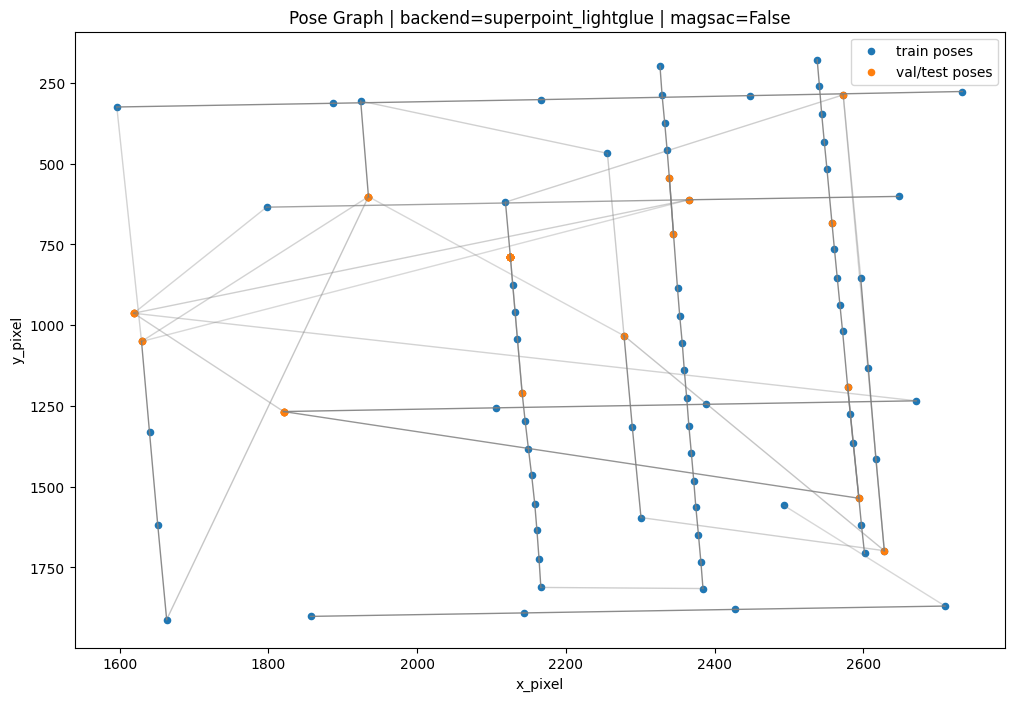

In [ ]:
# Schritt 2: Visualisierung (Kameras/Pose-Graph)
plot_pose_graph(
    fmap,
    min_edge_inliers=20,
    title=f'Pose Graph | backend={selected_backend.name} | magsac={selected_use_magsac}',
)


In [ ]:
# Schritt 2: COLMAP-Textmodell exportieren (fuer pycolmap / COLMAP GUI)
model_dir = export_colmap_text_model(
    fmap=fmap,
    out_dir=Path('../build/colmap_text_model'),
    min_track_len=2,
)
print('Exported model to:', model_dir)

# Optionales Laden mit pycolmap
try:
    from gdloc import try_load_pycolmap_reconstruction
    recon = try_load_pycolmap_reconstruction(model_dir)
    print('pycolmap reconstruction loaded:', recon)
except Exception as e:
    print('pycolmap nicht verfuegbar oder API abweichend:', e)


Exported model to: ../build/colmap_text_model
pycolmap reconstruction loaded: Reconstruction(num_rigs=120, num_cameras=120, num_frames=120, num_reg_frames=120, num_images=120, num_points3D=50561)


In [ ]:
# Schritt 2: Rekonstruktion wie im SE3Labs-Notebook anzeigen
# Bevorzugt: hloc/visualize Helfer. Fallback: interne Plotly-Visualisierung.
import numpy as np
import plotly.graph_objects as go

try:
    import pycolmap
except ImportError as e:
    raise ImportError("pycolmap ist nicht installiert. Installiere z.B. `pip install pycolmap`.") from e

colmap_reconstruction = pycolmap.Reconstruction(str(model_dir))

try:
    from hloc.utils.viz_3d import init_figure, plot_reconstruction
    viz_backend = "hloc.utils.viz_3d"
except Exception:
    try:
        from visualize import init_figure, plot_reconstruction
        viz_backend = "visualize.py"
    except Exception:
        viz_backend = "plotly_fallback"

        def init_figure():
            fig = go.Figure()
            fig.update_layout(
                scene=dict(aspectmode="data", xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
                margin=dict(l=0, r=0, t=40, b=0),
            )
            return fig

        def plot_reconstruction(fig, reconstruction, color="rgba(255,0,0,0.5)", name="reconstruction"):
            pts = [np.asarray(p.xyz, dtype=np.float64) for p in reconstruction.points3D.values()]
            if pts:
                pts = np.stack(pts, axis=0)
                fig.add_trace(
                    go.Scatter3d(
                        x=pts[:, 0],
                        y=pts[:, 1],
                        z=pts[:, 2],
                        mode="markers",
                        name=name,
                        marker=dict(size=1.5, color=color),
                    )
                )

            cam_centers = []
            for img in reconstruction.images.values():
                if not img.has_pose:
                    continue
                c = np.asarray(img.cam_from_world().inverse().translation, dtype=np.float64)
                cam_centers.append(c)

            if cam_centers:
                cams = np.stack(cam_centers, axis=0)
                fig.add_trace(
                    go.Scatter3d(
                        x=cams[:, 0],
                        y=cams[:, 1],
                        z=cams[:, 2],
                        mode="markers+lines",
                        name="cameras",
                        marker=dict(size=3, color="rgba(0,120,255,0.9)"),
                        line=dict(width=2, color="rgba(0,120,255,0.35)"),
                    )
                )
            return fig

print(f"visualization backend: {viz_backend}")

# Gleiches Usage-Muster wie im SE3Labs-Notebook
fig = init_figure()
plot_reconstruction(fig, colmap_reconstruction, color="rgba(255,0,0,0.5)", name="reconstruction")
fig.show()


visualization backend: hloc.utils.viz_3d


In [ ]:
# Punktwolke aller erkannten Keypoints (3D-Punkte der Rekonstruktion)
import numpy as np
import plotly.graph_objects as go

if 'colmap_reconstruction' not in globals():
    import pycolmap
    colmap_reconstruction = pycolmap.Reconstruction(str(model_dir))

pts = [np.asarray(p.xyz, dtype=np.float64) for p in colmap_reconstruction.points3D.values()]
if len(pts) == 0:
    print('Keine 3D-Keypoints in der Rekonstruktion vorhanden.')
else:
    pts = np.stack(pts, axis=0)
    print('num_3d_keypoints:', pts.shape[0])

    fig_cloud = go.Figure(
        data=[
            go.Scatter3d(
                x=pts[:, 0],
                y=pts[:, 1],
                z=pts[:, 2],
                mode='markers',
                marker=dict(size=1.4, color=pts[:, 2], colorscale='Viridis', opacity=0.9),
                name='all_keypoints',
            )
        ]
    )
    fig_cloud.update_layout(
        title='Point Cloud: alle erkannten Keypoints',
        scene=dict(aspectmode='data', xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        margin=dict(l=0, r=0, t=40, b=0),
    )
    fig_cloud.show()


In [ ]:
# Detailmetriken je Paar (nutzbar fuer Debug/Tuning)
pairs_df = fmap.pair_metrics_df()
display(pairs_df.head(20))
print('pairs:', len(pairs_df), 'tracks>=2:', len(fmap.tracks_as_list(min_track_len=2)))


backend  use_magsac  frame_id0  frame_id1  raw_matches  inliers  \
0    loftr       False         13         15           58       58   
1    loftr       False         15         16          299      299   
2    loftr       False         16         17          279      279   
3    loftr       False         17         18          281      281   
4    loftr       False         18         20           53       53   
5    loftr       False         20         21          338      338   
6    loftr       False         21         22          373      373   
7    loftr       False         22         24           60       60   
8    loftr       False         24         25           47       47   
9    loftr       False         25         26          321      321   
10   loftr       False         26         31           45       45   
11   loftr       False         31         32          323      323   
12   loftr       False         32         33          294      294   
13   loftr       False         33         34          333      333   
14   loftr       False         34         37           23       23   
15   loftr       False         37         38          379      379   
16   loftr       False         38         39          365      365   
17   loftr       False         39         40          333      333   
18   loftr       False         40         41          350      350   
19   loftr       False         41         45           40       40   

    inlier_ratio  match_time_ms  geom_time_ms  
0            1.0     506.772917      0.012408  
1            1.0     285.925124      0.010477  
2            1.0     303.956467      0.009686  
3            1.0     300.276520      0.009943  
4            1.0     310.150897      0.009460  
5            1.0     419.133348      0.009779  
6            1.0     296.506920      0.009225  
7            1.0     267.222948      0.008875  
8            1.0     268.778283      0.009423  
9            1.0     264.432735      0.008757  
10           1.0     253.558324      0.009315  
11           1.0     248.143255      0.008721  
12           1.0     281.042020      0.009558  
13           1.0     257.534572      0.008532  
14           1.0     253.314489      0.008379  
15           1.0     384.706796      0.009288  
16           1.0     233.220817      0.008595  
17           1.0     237.159649      0.009639  
18           1.0     262.198221      0.008586  
19           1.0     278.617381      0.008631

pairs: 119 tracks>=2: 42911
